# До. за.

Скачайте датасет с отзывами на фильмы. Например, используйте датасет [IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). 

Используйте для дообучения BERT датасет IMDB. 

Ответьте на вопросы:
1. удалось ли достичь такого же accuracy (98\%) при использовании IMDB датасета?
   - нет
2. удалось ли получить хорошее качество классификации всего за одну эпоху?
   - нет
3. подумайте, в чем может быть причина различий в дообучении одной и той же модели на разных датасетах
    - Внимательно изучите датасет с русскими твитами. В чем его особенности? Нет ли явных паттернов или ключевых слов, которые однозначно определяют сентимент твита?
        - там детерминированная авторазметка по смайликам, фактически НС ее вычислила, приблизила с почти 100% точность
    - Попробуйте удалить пунктуацию из датасета с русскими твитами и перезапустите дообучение модели. Изменилось ли итоговое качество работы модели? Почему?
      - потому что "пунктуация" это и есть смайлики по которым размечался датасет

In [1]:
# !cd ./datasets; wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz; tar -xf aclImdb_v1.tar.gz

QUICK_RUN = False

In [2]:
from pathlib import Path

N = 1000 # (N pos + N neg) for both train and test

def read_imdb_split(split_dir):
    split_dir = Path(split_dir)
    texts, labels = [], []
    for label_dir in ["pos", "neg"]:
        for i, text_file in enumerate((split_dir/label_dir).iterdir()):
            texts.append(text_file.read_text())
            labels.append(0 if label_dir == "neg" else 1)
            if QUICK_RUN and i == N - 1: 
                break

    return texts, labels

train_texts, train_labels = read_imdb_split('./datasets/aclImdb/train')
test_texts, test_labels = read_imdb_split('./datasets/aclImdb/test')

In [3]:
print(len(train_texts))

25000


Валидационная выборка

In [4]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2)

Токенизатор
- отзывы на английском

In [5]:
from transformers import DistilBertTokenizerFast, AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [6]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

Датасет

In [7]:
import torch

class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IMDbDataset(train_encodings, train_labels)
val_dataset = IMDbDataset(val_encodings, val_labels)
test_dataset = IMDbDataset(test_encodings, test_labels)

# Fine-tuning with native PyTorch/TensorFlow

In [14]:
BATCH_SIZE = 16

In [15]:
from transformers import AutoConfig

config = AutoConfig.from_pretrained('distilbert-base-uncased')
config.n_layers = 3
config.n_heads = 6
config.num_labels = 2

In [16]:
from transformers import DistilBertForSequenceClassification, AutoModelForSequenceClassification

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# model = AutoModelForSequenceClassification.from_pretrained("cointegrated/rubert-tiny", num_labels=2)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)

model.to(device)
pass

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['distilbert.transformer.layer.3.sa_layer_norm.weight', 'vocab_layer_norm.weight', 'distilbert.transformer.layer.5.ffn.lin1.bias', 'distilbert.transformer.layer.5.attention.out_lin.weight', 'distilbert.transformer.layer.3.attention.q_lin.bias', 'distilbert.transformer.layer.3.sa_layer_norm.bias', 'distilbert.transformer.layer.5.output_layer_norm.weight', 'distilbert.transformer.layer.4.attention.q_lin.weight', 'distilbert.transformer.layer.4.ffn.lin1.bias', 'vocab_projector.weight', 'distilbert.transformer.layer.4.attention.q_lin.bias', 'distilbert.transformer.layer.5.ffn.lin2.bias', 'distilbert.transformer.layer.5.sa_layer_norm.weight', 'distilbert.transformer.layer.4.sa_layer_norm.weight', 'vocab_projector.bias', 'distilbert.transformer.layer.5.output_layer_norm.bias', 'distilbert.transformer.layer.4.attention.out_lin.bias', 'vocab_transform.weight', 'd

In [17]:
from torch.utils.data import DataLoader
from torch.optim import AdamW

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
optim = AdamW(model.parameters(), lr=5e-5)

num_epochs = 1 if QUICK_RUN else 2
num_training_steps = num_epochs * len(train_loader)

- 19 минут

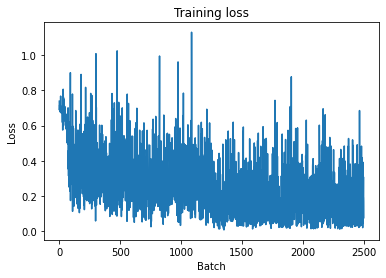

In [18]:
import matplotlib.pyplot as plt

from IPython.display import clear_output
from tqdm.auto import tqdm

loss_set = []
progress_bar = tqdm(range(num_training_steps))

model.train()

for epoch in range(num_epochs):
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()
        
        loss_set.append(loss.detach().cpu())  
        clear_output(True)
        plt.plot(loss_set)
        plt.title("Training loss")
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.show()
        progress_bar.update(1)

# Оценка качества на отложенной выборке

In [19]:
from sklearn.metrics import accuracy_score

model.eval()

eval_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_preds, valid_labels = [], []

for batch in eval_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    valid_preds.extend(predictions.detach().cpu().tolist())
    valid_labels.extend(batch["labels"].detach().cpu().tolist())


print("Процент правильных предсказаний на отложенной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на отложенной выборке: 89.47%


In [20]:
print('Неправильных предсказаний: {0}/{1}'.format(
    sum([z[0] != z[1] for z in zip(valid_labels,  valid_preds)]),
    len(valid_labels)
))

Неправильных предсказаний: 2632/25000
